In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from toyclown import GeoUnit, ToyClown

In [2]:
hierarchy = [("Country", 1, 810.), 
             ("State", 3, 270.), 
             ("County", 3, 90.), 
             ("Dist", 3, 30.)]

eps_budget = 0.4998 # I picked a random number from one of Peter's runs
eps_splits = [0, 0.33, 0.33, 0.34] 

clown = ToyClown(hierarchy, eps_budget, eps_splits)
clown.show() 

Country
├── CountryState1
│   ├── CountryState1County1
│   │   ├── CountryState1County1Dist1
│   │   ├── CountryState1County1Dist2
│   │   └── CountryState1County1Dist3
│   ├── CountryState1County2
│   │   ├── CountryState1County2Dist1
│   │   ├── CountryState1County2Dist2
│   │   └── CountryState1County2Dist3
│   └── CountryState1County3
│       ├── CountryState1County3Dist1
│       ├── CountryState1County3Dist2
│       └── CountryState1County3Dist3
├── CountryState2
│   ├── CountryState2County1
│   │   ├── CountryState2County1Dist1
│   │   ├── CountryState2County1Dist2
│   │   └── CountryState2County1Dist3
│   ├── CountryState2County2
│   │   ├── CountryState2County2Dist1
│   │   ├── CountryState2County2Dist2
│   │   └── CountryState2County2Dist3
│   └── CountryState2County3
│       ├── CountryState2County3Dist1
│       ├── CountryState2County3Dist2
│       └── CountryState2County3Dist3
└── CountryState3
    ├── CountryState3County1
    │   ├── CountryState3County1Dist1
    │   ├── C

In [3]:
# This is where everything from Proposition 1 happens.
clown.noise_and_adjust()

In [4]:
# How to look at the node's attributes
clown.get_node("CountryState3").data.__dict__

{'name': 'CountryState3',
 'unnoised_pop': 270.0,
 'parent': 'Country',
 'identifier': 'CountryState3',
 'level': 1,
 'noised_pop': 268.2862506801745,
 'noise': -1.713749319825511,
 'noise_type': 'laplacian',
 'adjusted_pop': 269.41048514973295,
 'error': -0.5895148502670509}

In [5]:
# A demonstration of Proposition 1, calculated for CountryState1
branching = 3
exp_1 = clown.get_node("CountryState1").data.noise
exp_2 = ( clown.get_node("CountryState1").data.noise \
        + clown.get_node("CountryState2").data.noise \
        + clown.get_node("CountryState3").data.noise ) / branching
exp_3 = clown.get_node("Country").data.error / branching

math.isclose(exp_1 - exp_2 + exp_3,
             clown.get_node("CountryState1").data.error,
             abs_tol=0.00001)

True

In [6]:
# 6 -level Trees
hierarchy = [("Country", 1, 900000.), 
             ("State", 3, 300000.), 
             ("County", 3, 100000.), 
             ("Tract", 10, 10000.),
             ("BlockGroup", 10, 1000.),
             ("Block", 10, 100.)]

eps_budget = 0.4998 # I picked a random number from one of Peter's runs
eps_splits = [0, 0, 0.25, 0.25, 0.25, 0.25] 

clown = ToyClown(hierarchy, eps_budget, eps_splits)
clown.noise_and_adjust()
clown.show() 

Country
├── CountryState1
│   ├── CountryState1County1
│   │   ├── CountryState1County1Tract1
│   │   │   ├── CountryState1County1Tract1BlockGroup1
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block1
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block10
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block2
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block3
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block4
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block5
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block6
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block7
│   │   │   │   ├── CountryState1County1Tract1BlockGroup1Block8
│   │   │   │   └── CountryState1County1Tract1BlockGroup1Block9
│   │   │   ├── CountryState1County1Tract1BlockGroup10
│   │   │   │   ├── CountryState1County1Tract1BlockGroup10Block1
│   │   │   │   ├── CountryState1County1Tract1BlockGroup10Block10
│   │   │   │   ├── Count

In [7]:
# First, a sanity check that the equation at the end of Prop 4 works
# We will do this check on CountryState1County1Tract1
p = 0.5
dist_blocks = []
other_blocks = []
tract = clown.get_node("CountryState1County1Tract1")
block_groups = clown.children(tract.identifier)

def set_diff(a, b):
    return list(set(a).difference(set(b)))

for bg in block_groups:
    blocks = clown.children(bg.identifier)
    chosen_blocks = np.random.choice(blocks, int(p*10), replace=False)
    
    dist_blocks.extend(chosen_blocks)
    other_blocks.extend(set_diff(blocks, chosen_blocks))

dist_blk_noises = [blk.data.noise for blk in dist_blocks]
other_blk_noises = [blk.data.noise for blk in other_blocks]
blk_errors = [blk.data.error for blk in dist_blocks]

math.isclose((1-p) * sum(dist_blk_noises) - p * sum(other_blk_noises) + p * tract.data.error,
             sum(blk_errors),
             abs_tol = 0.000001)

True

In [8]:
# get blk errors for p from 0 to 1
def get_district_errors_at_p(p, tract_name):
    dist_blocks = []
    other_blocks = []
    tract = clown.get_node(tract_name)
    block_groups = clown.children(tract.identifier)

    for bg in block_groups:
        blocks = clown.children(bg.identifier)
        chosen_blocks = np.random.choice(blocks, int(p*10), replace=False)
        dist_blocks.extend(chosen_blocks)

    raw_errors = [blk.data.error for blk in dist_blocks]
    abs_errors = [abs(err) for err in raw_errors]
    
    return sum(raw_errors), sum(abs_errors)

In [9]:
raw_error_sums = []
abs_error_sums = []
ps = np.linspace(0,1,11)
for p in ps:
    raw_err, abs_err = get_district_errors_at_p(p, "CountryState1County1Tract1")
    raw_error_sums.append(raw_err)
    abs_error_sums.append(abs_err)

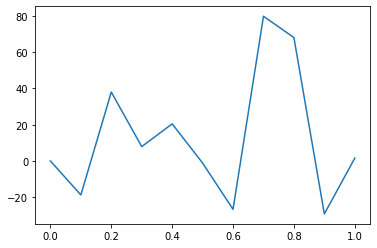

In [10]:
plt.plot(ps, raw_error_sums)

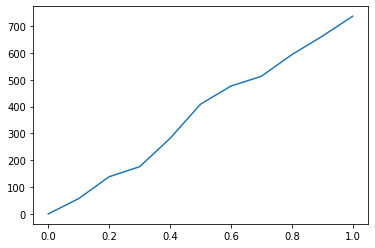

In [11]:
# we are probably more interested in the absolute value of the errors than the actual sum of errors
plt.plot(ps, abs_error_sums)

In [ ]:
# num_tracts = 10
# df = pd.DataFrame()
# df["p"] = ps

# for i in range(num_tracts):
#     tract_name = "CountryState1County1Tract" + str(i+1)
#     tract_errors = []
    
#     for p in ps:
#         raw_errs, abs_errs = get_district_errors_at_p(p, tract_name)
#         tract_errors_raw.append(err)
    
#     df["Tract" + str(i+1)] = tract_errors
    
# df = df.T
# df.columns = df.iloc[0]
# df.columns = ['%s' % float('%.1g' % f) for f in df.columns]
# df = df.drop('p')
# df.boxplot()